In [10]:
#Import All the Required Libraries..
import numpy as np
import pandas as pd
import re
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors

0it [00:00, ?it/s]


In [11]:
#import test and train data into dataframe..
os.getcwd()
os.chdir('D:\\Tusharg9\\GreayAtom\\15_Hackathon\\Hotstar')
train_data = pd.read_json('train_data.json',orient='index')
test_data = pd.read_json('test_data.json',orient='index')

In [12]:
#set index
train_data.reset_index(level = 0, inplace = True)
train_data.rename(columns={'index':'ID'}, inplace=True)

test_data.reset_index(level = 0, inplace = True)
test_data.rename(columns={'index':'ID'}, inplace=True)

In [13]:
#check data
print ('Train data Number of rows {} rows and {} columns'.format(train_data.shape[0],train_data.shape[1]))
print ('test_data data Number of rows {} rows and {} columns'.format(test_data.shape[0],test_data.shape[1]))

Train data Number of rows 200000 rows and 7 columns
test_data data Number of rows 100000 rows and 6 columns


In [14]:
#Encode Target Variable
train_data = train_data.replace({'segment':{'pos':1,'neg':0}})


In [15]:
test_data = test_data.replace({'segment':{'pos':1,'neg':0}})

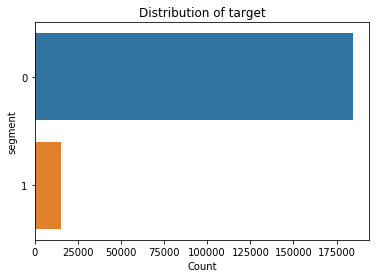

In [16]:
# Plotting distribution of Segments:
sns.countplot(y='segment', data=train_data)
plt.ylabel('segment')
plt.xlabel('Count')
plt.title('Distribution of target')
plt.show()

In [17]:
#check target variable count
train_data['segment'].value_counts()/train_data.shape[0]

0    0.923725
1    0.076275
Name: segment, dtype: float64

In [18]:
# Creating separate columns for genres
genre_data = [[str("genre_" + i) for i in re.sub(pattern='\:\d+',repl='',string=x).split(",")] for x in train_data['genres']]
genre_data = frozenset.union(*pd.Series(genre_data).apply(frozenset))

In [19]:
cities_data = [[str("cities_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['cities']]
cities_data = frozenset.union(*pd.Series(cities_data).apply(frozenset))

In [20]:
dow_data = [[str("dow_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['dow']]
dow_data = frozenset.union(*pd.Series(dow_data).apply(frozenset))

In [21]:
tod_data = [[str("tod_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['tod']]
tod_data = frozenset.union(*pd.Series(tod_data).apply(frozenset))

In [22]:
def get_genre_freq(row):
        
    genre_dict = {}
    for genre in row.genres.split(","):
        genre_name, genre_wt = genre.split(":")
        genre_dict[str("genre_" + genre_name)] = int(genre_wt)
    
    genre_freq = {}
    for i in genre_data:
        if i in genre_dict:
            genre_freq[i] = genre_dict[i] 
        else:
            genre_freq[i] = 0            

    return pd.Series(genre_freq)

In [23]:
genre_feats = train_data.progress_apply(get_genre_freq, axis = 1)

200001it [03:57, 841.10it/s] 


In [24]:
def get_dow_freq(row):
    
    dow_dict = {}
    for dow in row.dow.split(","):
        dow_name, dow_wt = dow.split(":")
        dow_dict[str("dow_" + dow_name)] = int(dow_wt)
    
    dow_freq = {}
    for i in dow_data:
        if i in dow_dict:
            dow_freq[i] = dow_dict[i] 
        else:
            dow_freq[i] = 0            

    return pd.Series(dow_freq)

def get_tod_freq(row):
    
    tod_dict = {}
    for tod in row.tod.split(","):
        tod_name, tod_wt = tod.split(":")
        tod_dict[str("tod_" + tod_name)] = int(tod_wt)
    
    tod_freq = {}
    for i in tod_data:
        if i in tod_dict:
            tod_freq[i] = tod_dict[i] 
        else:
            tod_freq[i] = 0            

    return pd.Series(tod_freq)

In [25]:
dow_feats = train_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = train_data.progress_apply(get_tod_freq, axis = 1)

100%|██████████| 200000/200000 [02:33<00:00, 1300.63it/s]


In [26]:
train_data = pd.concat([train_data, genre_feats], axis = 1)
train_data = pd.concat([train_data, dow_feats], axis = 1)
train_data = pd.concat([train_data, tod_feats], axis = 1)

In [27]:
genre_feats = test_data.progress_apply(get_genre_freq, axis = 1)
dow_feats = test_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = test_data.progress_apply(get_tod_freq, axis = 1)

test_data = pd.concat([test_data, genre_feats], axis = 1)
test_data = pd.concat([test_data, dow_feats], axis = 1)
test_data = pd.concat([test_data, tod_feats], axis = 1)

100%|██████████| 100000/100000 [01:19<00:00, 1255.55it/s]


In [28]:
metro_cities = ['mumbai','delhi','kolkata','chennai','bengaluru','hyderabad','ahmadabad','pune','surat','jaipur','kanpur','lucknow','nagpur','ghaziabad','indore','coimbatore','kochi','patna','kozhikode','bhopal','thrissur','vadodara','agra','malappuram','thiruvananthapuram','kannur','ludhiana','nashik','vijayawada','madurai','varanasi','meerut','faridabad','rajkot','jamshedpur','srinagar','jabalpur','asansol','vasai virar city','allahabad','dhanbad','aurangabad','amritsar','jodhpur','ranchi','raipur','kollam','gwalior','durg-bhilainagar','chandigarh','tiruchirappalli','kota']
cities_metro = ['metro','non_metro']
def get_Metro_freq(row):
    cities_dict = {}
    for city in row.cities.split(","):
        city_name, city_wt = city.split(":")
        if city_name.lower() in metro_cities:
            cities_dict[str("metro")] = int(city_wt)
        else:
            cities_dict[str("non_metro")] = int(city_wt)   
    
    metro_freq = {}
    for x in cities_metro:
        if x in cities_dict:
            metro_freq[x] = cities_dict[x]
        else:
            metro_freq[x] = 0            

    return pd.Series(metro_freq)

In [29]:
metro_feats = train_data.progress_apply(get_Metro_freq, axis = 1)

100%|██████████| 200000/200000 [02:31<00:00, 1320.01it/s]


In [30]:
train_data = pd.concat([train_data, metro_feats], axis = 1)
metro_feats

,metro,non_metro
0,64,0
1,26989,56666
2,0,29400
3,0,4005
4,0,2864
5,0,5
6,13142,3885
7,77,373
8,19504,1124
9,0,104


In [31]:
metro_feats = test_data.progress_apply(get_Metro_freq, axis = 1)
test_data = pd.concat([test_data, metro_feats], axis = 1)

100%|██████████| 100000/100000 [01:17<00:00, 1296.76it/s]


In [32]:
# sum of watch time from titles

def get_sum_wt(row):
    
    sum_wt = 0
    
    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            sum_wt += int(title_wt)
            
        except:
            pass
        
    return sum_wt

train_data["sum_wt"] = train_data.progress_apply(get_sum_wt, axis = 1)
test_data["sum_wt"] = test_data.progress_apply(get_sum_wt, axis = 1)

100%|██████████| 100000/100000 [00:07<00:00, 14236.10it/s]


In [33]:
#Create Count variables
def get_count(feature):
    return feature.count(',')+1

train_data['title_count'] = train_data['titles'].map(get_count)
train_data['genres_count'] = train_data['genres'].map(get_count)
train_data['cities_count'] = train_data['cities'].map(get_count)
train_data['tod_count'] = train_data['tod'].map(get_count)
train_data['dow_count'] = train_data['dow'].map(get_count)

#test_data['title_count'] = test_data['titles'].map(get_count)
#test_data['genres_count'] = test_data['genres'].map(get_count)
#test_data['cities_count'] = test_data['cities'].map(get_count)
#test_data['tod_count'] = test_data['tod'].map(get_count)
#test_data['dow_count'] = test_data['dow'].map(get_count)



In [34]:
dow_1_sum= train_data['dow_1'].sum()
dow_2_sum= train_data['dow_2'].sum()
dow_3_sum= train_data['dow_3'].sum()
dow_4_sum= train_data['dow_4'].sum()
dow_5_sum= train_data['dow_5'].sum()
dow_6_sum= train_data['dow_6'].sum()
dow_7_sum= train_data['dow_7'].sum()
dow_sum=[dow_1_sum, dow_2_sum, dow_3_sum, dow_4_sum, dow_5_sum, dow_6_sum, dow_7_sum]
dow_sum

[565542985, 543678498, 540798186, 659711445, 593545037, 624329762, 721431991]

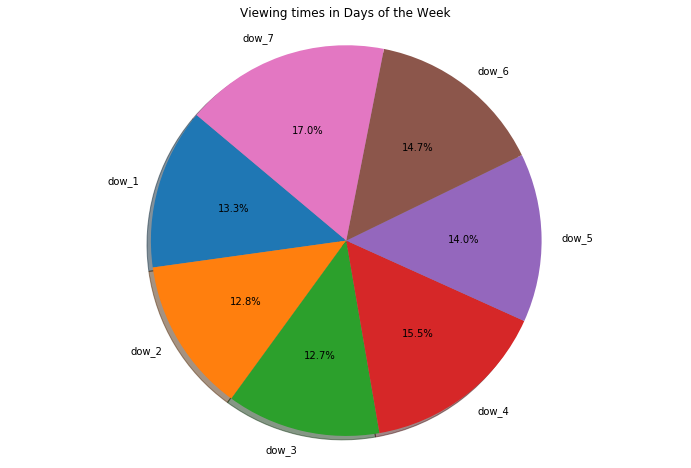

In [35]:
days_of_week = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red','yellow', 'cyan']
plt.figure(figsize=(12,8))
plt.pie(dow_sum, labels=['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6','dow_7'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing times in Days of the Week')
plt.show()

In [36]:
train_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)
#test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [37]:
test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [38]:
train_data.to_csv('final_train_test.csv')

In [39]:
test_data.to_csv('final_test.csv')

In [ ]:
#new_data_frame = train_data.copy()
#train_data = new_data_frame

In [40]:
train_data.columns


Index(['ID', 'segment', 'genre_Hockey', 'genre_Romance', 'genre_Athletics',
       'genre_Horror', 'genre_Drama', 'genre_Travel', 'genre_Table Tennis',
       'genre_Cricket', 'genre_Reality', 'genre_Boxing', 'genre_Teen',
       'genre_FormulaE', 'genre_IndiaVsSa', 'genre_LiveTV', 'genre_Family',
       'genre_Swimming', 'genre_Awards', 'genre_Mythology', 'genre_TalkShow',
       'genre_Football', 'genre_Formula1', 'genre_Badminton', 'genre_Tennis',
       'genre_NA', 'genre_Action', 'genre_Thriller', 'genre_Crime',
       'genre_Science', 'genre_Kids', 'genre_Volleyball', 'genre_Sport',
       'genre_Wildlife', 'genre_Kabaddi', 'genre_Documentary', 'genre_Comedy',
       'dow_2', 'dow_3', 'dow_7', 'dow_1', 'dow_5', 'dow_6', 'dow_4', 'tod_7',
       'tod_21', 'tod_19', 'tod_2', 'tod_9', 'tod_5', 'tod_3', 'tod_6',
       'tod_20', 'tod_22', 'tod_12', 'tod_11', 'tod_1', 'tod_17', 'tod_18',
       'tod_23', 'tod_4', 'tod_8', 'tod_0', 'tod_14', 'tod_10', 'tod_16',
       'tod_13', 'tod_15

In [41]:
def similar_genre_feature(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    #remaining_genres = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller"]
    #df["generated_positive"] = 0

    remaining_genres = []
    
    for i in df.columns:
        if "genre_" in i and i not in sports_feats:
            remaining_genres.append(i)
    

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_genres])
    sum_wt += df["generated_sports"]
    
    df["generated_sports_ratio"] = df["generated_sports"]/sum_wt    
    
    for i in remaining_genres:
        df[i+"_ratio"] = df[i]/sum_wt
            
    return df

In [42]:
def generate_tod_features(df):
    night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
    df["generated_night"] = 0
    
    morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
    df["generated_morning"] = 0
    
    afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
    df["generated_afternoon"] = 0
    
    evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
    df["generated_evening"] = 0

    for i in night_feats:
        df["generated_night"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in morning_feats:
        df["generated_morning"] += df[i]
        df.drop(i, axis = 1, inplace = True)
        
    for i in afternoon_feats:
        df["generated_afternoon"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in evening_feats:
        df["generated_evening"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = df["generated_night"] + df["generated_morning"] + df["generated_afternoon"] + df["generated_evening"]

    df["night_tod_ratio"] = df["generated_night"]/sum_wt
    df["morning_tod_ratio"] = df["generated_morning"]/sum_wt
    df["afternoon_tod_ratio"] = df["generated_afternoon"]/sum_wt                                                  
    df["evening_tod_ratio"] = df["generated_evening"]/sum_wt
    
    return df

In [43]:
def generate_wod_features(df):

    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5", "dow_6", "dow_7"]
    sum_wt = sum([df[i] for i in weekday_feats])
    df["weekend_ratio"] = (df["dow_7"] + df["dow_6"])/sum_wt
    df["weekday_ratio"] = 1 - df["weekend_ratio"]
    
    return df

In [44]:
def generate_cities_features(df):
    sum_wt = df["metro"] + df["non_metro"]
    df["metro_ratio"] = df["metro"]/sum_wt
    df["non_metro_ratio"] = df["non_metro"]/sum_wt
    return df

In [45]:
df_new = similar_genre_feature(train_data)

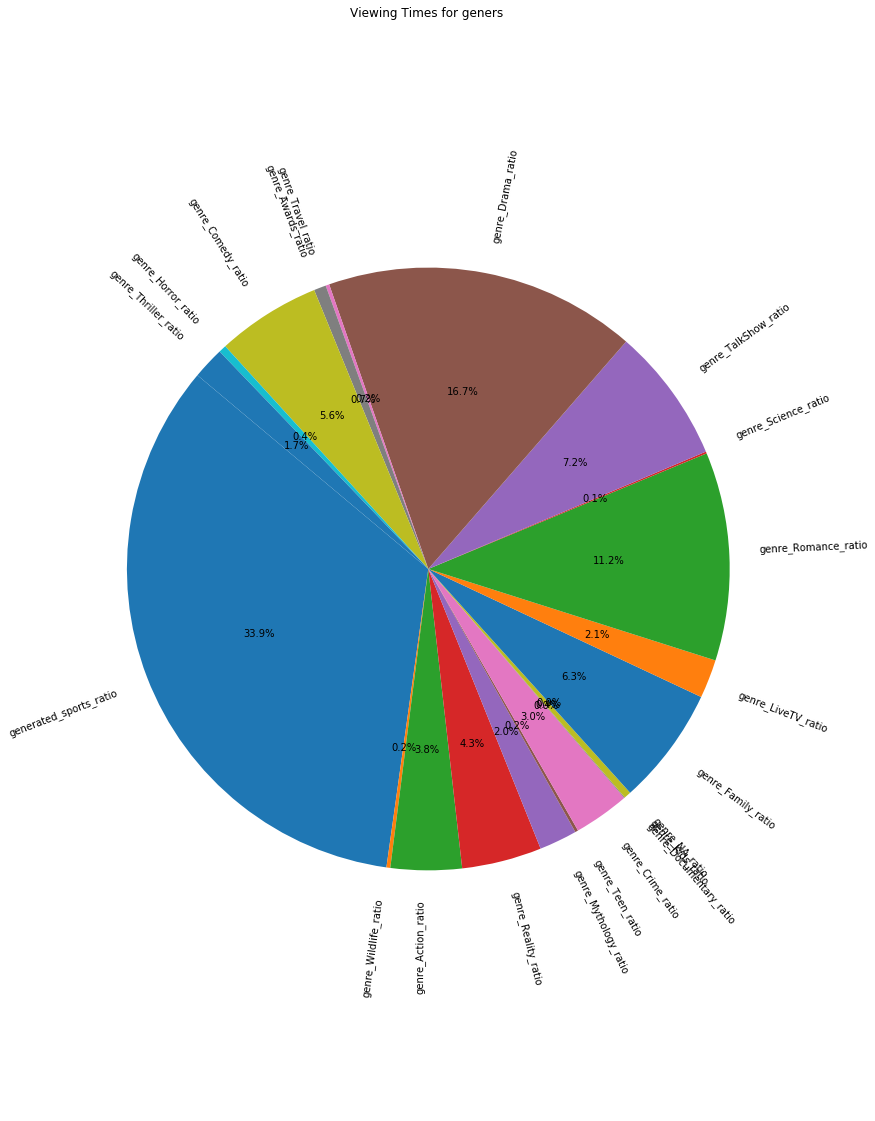

In [46]:
labels = ['generated_sports_ratio', 'genre_Wildlife_ratio',
       'genre_Action_ratio', 'genre_Reality_ratio', 'genre_Mythology_ratio',
       'genre_Teen_ratio', 'genre_Crime_ratio', 'genre_Documentary_ratio',
       'genre_Kids_ratio', 'genre_NA_ratio', 'genre_Family_ratio',
       'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Science_ratio',
       'genre_TalkShow_ratio', 'genre_Drama_ratio', 'genre_Travel_ratio',
       'genre_Awards_ratio', 'genre_Comedy_ratio', 'genre_Horror_ratio',
       'genre_Thriller_ratio']

sum_geners = [df_new['generated_sports_ratio'].sum(), df_new['genre_Wildlife_ratio'].sum(),
       df_new['genre_Action_ratio'].sum(), df_new['genre_Reality_ratio'].sum(), df_new['genre_Mythology_ratio'].sum(),
       df_new['genre_Teen_ratio'].sum(), df_new['genre_Crime_ratio'].sum(), df_new['genre_Documentary_ratio'].sum(),
       df_new['genre_Kids_ratio'].sum(), df_new['genre_NA_ratio'].sum(), df_new['genre_Family_ratio'].sum(),
       df_new['genre_LiveTV_ratio'].sum(), df_new['genre_Romance_ratio'].sum(), df_new['genre_Science_ratio'].sum(),
       df_new['genre_TalkShow_ratio'].sum(), df_new['genre_Drama_ratio'].sum(), df_new['genre_Travel_ratio'].sum(),
       df_new['genre_Awards_ratio'].sum(), df_new['genre_Comedy_ratio'].sum(), df_new['genre_Horror_ratio'].sum(),
       df_new['genre_Thriller_ratio'].sum()]
plt.figure(figsize=(12,20))
plt.pie(sum_geners, labels=labels,
       autopct='%1.1f%%',  startangle=140, rotatelabels=True)
plt.axis('equal')
plt.title('Viewing Times for geners')
plt.show()

In [47]:
df_new = generate_tod_features(train_data)

In [48]:
tod_sum_wt = [df_new["generated_night"].sum() , df_new["generated_afternoon"].sum() , df_new["generated_evening"].sum(),df_new["generated_morning"].sum()]
tod_sum_wt

[545548434, 1426059749, 1610752873, 666613752]

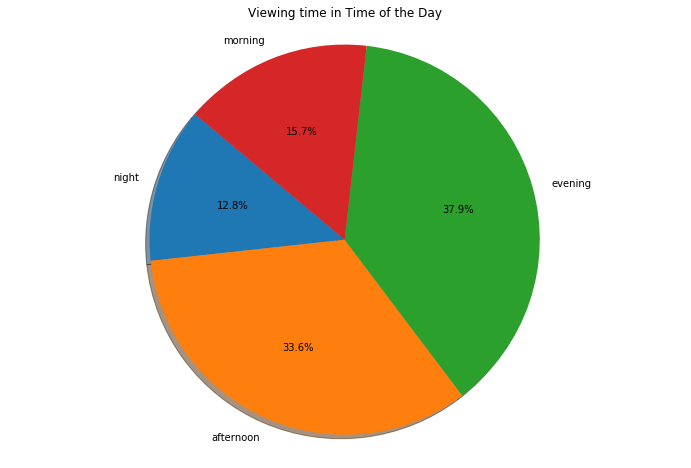

In [49]:
colors_tod = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(12,8))
plt.pie(tod_sum_wt, labels=['night','afternoon','evening','morning'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing time in Time of the Day')
plt.show()

In [50]:
df_new = generate_wod_features(train_data)

In [51]:
df_new  = generate_cities_features(train_data)

In [52]:
df_new.to_csv('train_data_new.csv')

In [53]:
df_test_new = generate_tod_features(test_data)
df_test_new = similar_genre_feature(test_data)
df_test_new = generate_wod_features(test_data)
df_test_new  = generate_cities_features(test_data)

In [54]:
df_test_new.to_csv('test_data_new.csv')

D:\Users\TUSHARG\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


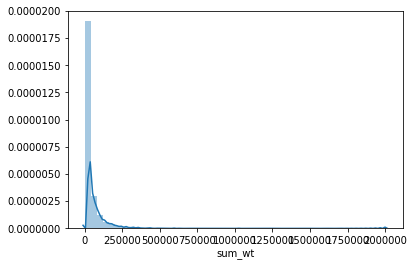

In [55]:
sns.distplot(df_new[df_new.segment == 1].sum_wt)
plt.show()

D:\Users\TUSHARG\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


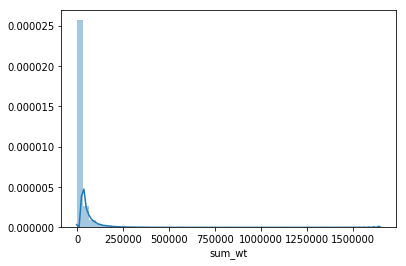

In [56]:
sns.distplot(df_new[df_new.segment == 0].sum_wt)
plt.show()

In [58]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000e+00
genre_Romance,15255.0,9405.176926,35557.194713,0.0,0.000000,34.000000,5441.500000,2.003185e+06
genre_Horror,15255.0,66.417437,1009.797066,0.0,0.000000,0.000000,0.000000,5.945500e+04
genre_Drama,15255.0,10814.095051,30646.106065,0.0,0.000000,456.000000,7896.000000,1.307902e+06
genre_Travel,15255.0,18.876762,542.217385,0.0,0.000000,0.000000,0.000000,4.590700e+04
genre_Reality,15255.0,963.399869,5546.414251,0.0,0.000000,0.000000,1.000000,2.126130e+05
genre_Teen,15255.0,229.727040,7055.379055,0.0,0.000000,0.000000,0.000000,6.054360e+05
genre_LiveTV,15255.0,77.338315,1519.662122,0.0,0.000000,0.000000,0.000000,1.552080e+05
genre_Family,15255.0,5233.363618,18905.027152,0.0,0.000000,0.000000,1531.500000,6.753350e+05
genre_Awards,15255.0,99.228581,894.318523,0.0,0.000000,0.000000,0.000000,2.351300e+04


In [59]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA"]#,"genre_LiveTV","genre_Wildlife","generated_sports"]
df_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [60]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_test_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_test_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA","genre_LiveTV","genre_Wildlife","generated_sports"]
df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [61]:
#somemore_genres_columns = ["genre_LiveTV","genre_Wildlife","generated_sports"]
#df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [62]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
genre_LiveTV,15255.0,77.338315,1519.662122,0.0,0.000000,0.000000,0.000000,155208.000000
genre_Wildlife,15255.0,8.800656,382.275589,0.0,0.000000,0.000000,0.000000,43799.000000
title_count,15255.0,8.012455,9.835222,1.0,2.000000,5.000000,10.000000,186.000000
genres_count,15255.0,3.247263,2.071606,1.0,2.000000,3.000000,4.000000,18.000000
cities_count,15255.0,2.058276,1.352105,1.0,1.000000,2.000000,3.000000,16.000000
tod_count,15255.0,8.806490,6.005727,1.0,3.000000,8.000000,13.000000,24.000000
dow_count,15255.0,4.496296,2.284612,1.0,2.000000,5.000000,7.000000,7.000000
generated_sports,15255.0,845.520485,4928.095744,0.0,0.000000,0.000000,0.000000,145748.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000


In [63]:
dropping_columns = ["ID", "dow_count", "tod_count", "genres_count", "cities_count", "title_count"]
df_new.drop(dropping_columns,axis=1,inplace = True)

In [64]:
dropping_columns = ["ID"]
df_test_new.drop(dropping_columns,axis=1,inplace = True)

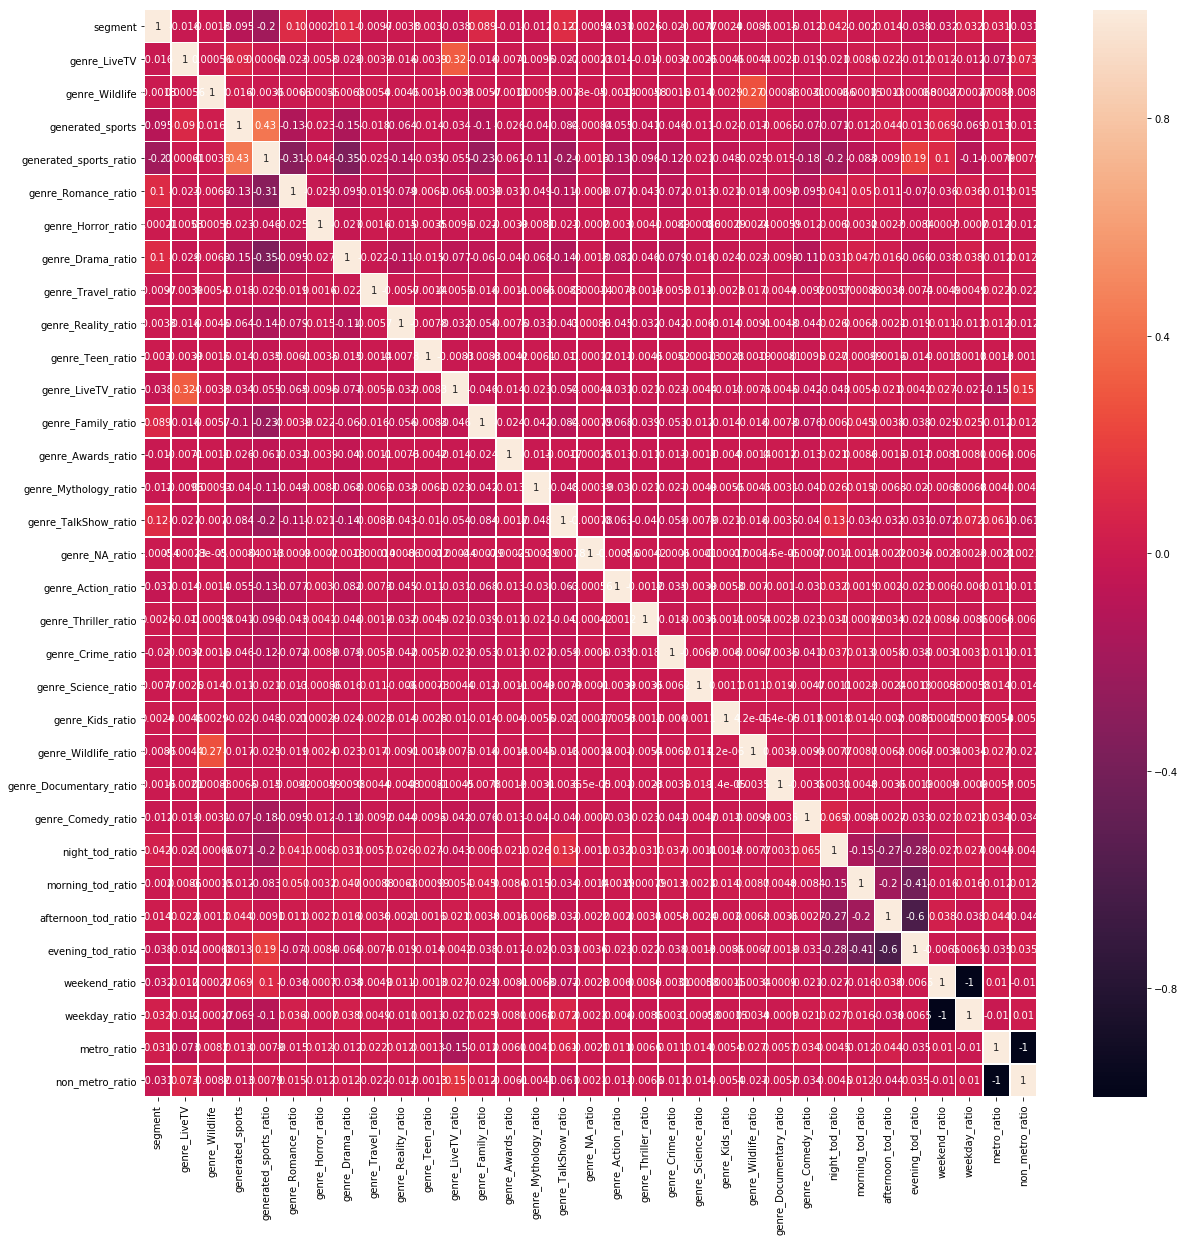

In [65]:
Var_Corr = df_new.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,linewidths=.5, ax=ax)

In [66]:
import matplotlib.pyplot as plt
plt.show()

In [67]:
# Plotting distribution of Segments:
#sns.countplot(y='metro_ratio', data=df_new)
#plt.ylabel('matro_ratio')
#plt.xlabel('Count')
#plt.title('Distribution of metros')
#plt.show()

In [68]:
df_new.to_csv('intermidate_state.csv')

In [69]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
genre_LiveTV,15255.0,77.338315,1519.662122,0.0,0.000000,0.000000,0.000000,155208.000000
genre_Wildlife,15255.0,8.800656,382.275589,0.0,0.000000,0.000000,0.000000,43799.000000
generated_sports,15255.0,845.520485,4928.095744,0.0,0.000000,0.000000,0.000000,145748.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000
genre_Romance_ratio,15255.0,0.201991,0.308986,0.0,0.000000,0.004301,0.315629,1.000000
genre_Horror_ratio,15255.0,0.004110,0.051497,0.0,0.000000,0.000000,0.000000,1.000000
genre_Drama_ratio,15255.0,0.277114,0.352059,0.0,0.000000,0.064449,0.511739,1.000000
genre_Travel_ratio,15255.0,0.000809,0.018425,0.0,0.000000,0.000000,0.000000,1.000000
genre_Reality_ratio,15255.0,0.040708,0.155611,0.0,0.000000,0.000000,0.000013,1.000000


In [70]:
df_new.to_csv('intermidate_state.csv')

In [71]:
#30 Features 
df_new.shape

(200000, 33)

In [72]:
df_test_new.shape

(100000, 29)

In [73]:
df_test_new[df_new.segment == 1].describe().transpose()

D:\Users\TUSHARG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
night_tod_ratio,7552.0,0.104841,0.223846,0.0,0.000000,0.000000,0.086322,1.000000
morning_tod_ratio,7552.0,0.138985,0.234613,0.0,0.000000,0.018586,0.181046,1.000000
afternoon_tod_ratio,7552.0,0.327197,0.318086,0.0,0.009734,0.254663,0.529071,1.000000
evening_tod_ratio,7552.0,0.428977,0.346156,0.0,0.103863,0.381930,0.713164,1.000000
generated_sports_ratio,7552.0,0.316528,0.399261,0.0,0.000000,0.019600,0.747262,0.999962
genre_Romance_ratio,7552.0,0.109476,0.248401,0.0,0.000000,0.000000,0.036990,1.000000
genre_Horror_ratio,7552.0,0.003993,0.050218,0.0,0.000000,0.000000,0.000000,1.000000
genre_Drama_ratio,7552.0,0.166570,0.299556,0.0,0.000000,0.000000,0.193288,1.000000
genre_Travel_ratio,7552.0,0.001942,0.034550,0.0,0.000000,0.000000,0.000000,1.000000
genre_Reality_ratio,7552.0,0.041446,0.157263,0.0,0.000000,0.000000,0.000430,1.000000


In [74]:
df_new.columns

Index(['segment', 'genre_LiveTV', 'genre_Wildlife', 'generated_sports',
       'generated_sports_ratio', 'genre_Romance_ratio', 'genre_Horror_ratio',
       'genre_Drama_ratio', 'genre_Travel_ratio', 'genre_Reality_ratio',
       'genre_Teen_ratio', 'genre_LiveTV_ratio', 'genre_Family_ratio',
       'genre_Awards_ratio', 'genre_Mythology_ratio', 'genre_TalkShow_ratio',
       'genre_NA_ratio', 'genre_Action_ratio', 'genre_Thriller_ratio',
       'genre_Crime_ratio', 'genre_Science_ratio', 'genre_Kids_ratio',
       'genre_Wildlife_ratio', 'genre_Documentary_ratio', 'genre_Comedy_ratio',
       'night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio',
       'evening_tod_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio',
       'non_metro_ratio'],
      dtype='object')

In [75]:
df_test_new.columns

Index(['night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio',
       'evening_tod_ratio', 'generated_sports_ratio', 'genre_Romance_ratio',
       'genre_Horror_ratio', 'genre_Drama_ratio', 'genre_Travel_ratio',
       'genre_Reality_ratio', 'genre_Teen_ratio', 'genre_LiveTV_ratio',
       'genre_Family_ratio', 'genre_Awards_ratio', 'genre_Mythology_ratio',
       'genre_TalkShow_ratio', 'genre_NA_ratio', 'genre_Action_ratio',
       'genre_Thriller_ratio', 'genre_Crime_ratio', 'genre_Science_ratio',
       'genre_Kids_ratio', 'genre_Wildlife_ratio', 'genre_Documentary_ratio',
       'genre_Comedy_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio',
       'non_metro_ratio'],
      dtype='object')

In [76]:
df_test_new["segment"] = np.nan

In [77]:
df_test_new.to_csv('final_test_data.csv')

In [100]:
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [101]:
x=df_new.drop('segment',axis=1)
y=df_new['segment']

In [102]:
x_train,x_test,y_train,y_test=tts(x,y,test_size= 0.3,random_state=42)

In [103]:
nb=GaussianNB()

In [104]:
x_train.fillna(x_train.mean(),inplace=True)
x_test.fillna(x_test.mean(),inplace=True)

D:\Users\TUSHARG\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [126]:
NavB=nb.fit(x_train,y_train)

In [127]:
y_pred=NavB.predict(x_test)

In [128]:
accuracy_score(y_test, y_pred, normalize = True)

0.7786166666666666

In [120]:
#Find Roc_Auc Score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
Naive_roc_auc = roc_auc_score(y_test, (y_pred))
print('AUC_ROC Score is:' + str(Naive_roc_auc))

AUC_ROC Score is:0.6582665729311108


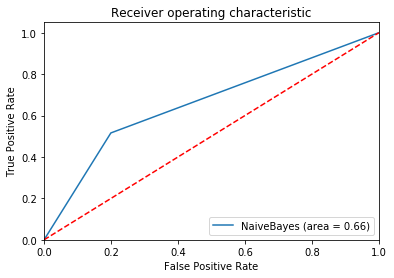

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % Naive_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [121]:
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[44335 11049]
 [ 2234  2382]]


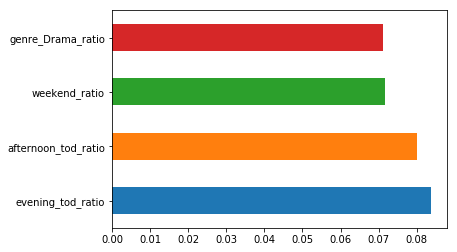

In [124]:
#Feature Importance graph
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline            

x=df_new.drop('segment',axis=1)
y=df_new['segment']

x.fillna(x.mean(),inplace=True)
y.fillna(y.mean(),inplace=True)

model = RandomForestClassifier()
model.fit(x, y)

(pd.Series(model.feature_importances_, index=x.columns)
   .nlargest(4)
   .plot(kind='barh')) 

In [129]:
import operator
importance = NavB.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

AttributeError: 'GaussianNB' object has no attribute 'get_fscore'